## Import Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from matplotlib.pyplot import imshow
import matplotlib.cm as cm
import matplotlib.pylab as plt
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import PIL
from PIL import ImageFilter
import cv2
import itertools
import random
import keras
from keras import utils as np_utils
import tensorflow as tf
import imutils
from imutils import paths
import os
from keras import optimizers
from tensorflow.keras.utils import img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras import callbacks
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, ZeroPadding2D
from keras.layers import Conv2D, MaxPooling2D , UpSampling2D , Conv1D, MaxPooling1D, UpSampling1D
from keras import backend as K
import pandas as pd
# %matplotlib inline

In [4]:
def pil_image(img_path):
    # convert image into gray scale
    pil_im =PIL.Image.open(img_path).convert('L')
    pil_im=pil_im.resize((105,105))
    #imshow(np.asarray(pil_im))
    return pil_im

## Augumentation Steps
1) Noise 2) Blur 3) Perpective Rotation 4) Shading 5) Variable Character Spacing 6) Variable Aspect Ratio

In [5]:
def noise_image(pil_im):
    # Adding Noise to image
    img_array = np.asarray(pil_im)
    mean = 0.0   # some constant
    std = 5   # some constant (standard deviation)
    noisy_img = img_array + np.random.normal(mean, std, img_array.shape)
    noisy_img_clipped = np.clip(noisy_img, 0, 255)
    noise_img = PIL.Image.fromarray(np.uint8(noisy_img_clipped)) # output
    #imshow((noisy_img_clipped ).astype(np.uint8))
    noise_img=noise_img.resize((105,105))
    return noise_img

In [6]:
def blur_image(pil_im):
    #Adding Blur to image
    blur_img = pil_im.filter(ImageFilter.GaussianBlur(radius=3)) # ouput
    #imshow(blur_img)
    blur_img=blur_img.resize((105,105))
    return blur_img

In [7]:
def affine_rotation(img):

    #img=cv2.imread(img_path,0)
    rows, columns = img.shape

    point1 = np.float32([[10, 10], [30, 10], [10, 30]])
    point2 = np.float32([[20, 15], [40, 10], [20, 40]])

    A = cv2.getAffineTransform(point1, point2)

    output = cv2.warpAffine(img, A, (columns, rows))
    affine_img = PIL.Image.fromarray(np.uint8(output)) # affine rotated output
    #imshow(output)
    affine_img=affine_img.resize((105,105))
    return affine_img

In [21]:
def gradient_fill(image):
    #image=cv2.imread(img_path,0)
    laplacian = cv2.Laplacian(image,cv2.CV_64F)
    laplacian = cv2.resize(laplacian, (105, 105))
    return laplacian

## Preparing Dataset

In [22]:
data_path = "/content/drive/MyDrive/master/augmented data"
data=[]
labels=[]
imagePaths = sorted(list(paths.list_images(data_path)))
random.seed(42)
random.shuffle(imagePaths)

In [23]:
def conv_label(label):
    if label == 'no':
        return 0
    elif label == 'yes':
        return 1

In [24]:
augument=["blur","noise","affine","gradient"]
a=itertools.combinations(augument, 4)

for i in list(a):
    print(list(i))

print(len(imagePaths))

['blur', 'noise', 'affine', 'gradient']
910


In [25]:
imagePaths[0].split(os.path.sep)[-2]

'no'

## Augment Function for Images

14560


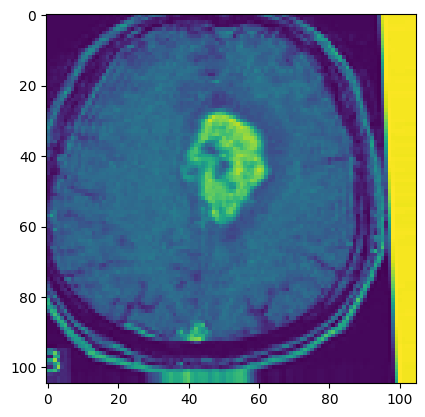

In [26]:
counter=0
for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    label = conv_label(label)
    pil_img = pil_image(imagePath)
    imshow(pil_img)

    # Adding original image
    org_img = img_to_array(pil_img)
    #print(org_img.shape)
    data.append(org_img)
    labels.append(label)

    augument=["noise","blur","affine","gradient"]
    for l in range(0,len(augument)):

        a=itertools.combinations(augument, l+1)

        for i in list(a):
            combinations=list(i)
            #print(len(combinations))
            temp_img = pil_img
            for j in combinations:

                if j == 'noise':
                    # Adding Noise image
                    temp_img = noise_image(temp_img)

                elif j == 'blur':
                    # Adding Blur image
                    temp_img = blur_image(temp_img)
                    #imshow(blur_img)

                elif j == 'affine':
                    open_cv_affine = np.array(pil_img)
                    # Adding affine rotation image
                    temp_img = affine_rotation(open_cv_affine)

                elif j == 'gradient':
                    open_cv_gradient = np.array(pil_img)
                    # Adding gradient image
                    temp_img = gradient_fill(open_cv_gradient)

            temp_img = img_to_array(temp_img)
            data.append(temp_img)
            labels.append(label)

print(len(data))

In [27]:
data = np.asarray(data, dtype="int") / 255.0
labels = np.array(labels)
print("Success")

Success


In [28]:
labels

array([0, 0, 0, ..., 1, 1, 1])

In [29]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) =  train_test_split(data,labels, test_size=0.25, random_state=42)
# convert the labels from integers to vectors
try:
    trainY = to_categorical(trainY, num_classes=2) ## input of to_categorial is class vector of integers
    print(trainY)
except Exception as ex:
    trainY = None
    print(ex)
try:
    testY = to_categorical(testY, num_classes=2)
    print(testY)
except Exception as ex:
    testY = None
    print(ex)

[[1. 0.]
 [0. 1.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]
[[0. 1.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [1. 0.]]


In [30]:
print(trainY.shape, trainX.shape)
print(testY.shape, testX.shape)

(10920, 2) (10920, 105, 105, 1)
(3640, 2) (3640, 105, 105, 1)


In [31]:
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,horizontal_flip=True)

## LPQ Feature Calculation

In [32]:
from scipy.signal import convolve2d

class LPQ(object):
    """ This implementation of Local Phase Quantization (LPQ) is a

      Reference:
        Ojansivu V & Heikkilä J (2008) Blur insensitive texture classification
        using local phase quantization. Proc. Image and Signal Processing
	(ICISP 2008), Cherbourg-Octeville, France, 5099:236-243.
        Copyright 2008 by Heikkilä & Ojansivu
    """

    def __init__(self, radius=3):
        self.radius = radius

    def euc_dist(self, X):
        Y = X = X.astype(np.int32)
        XX = np.sum(X * X, axis=1)[:, np.newaxis]
        YY = XX.T
        distances = np.dot(X,Y.T)
        distances *= -2
        distances += XX
        distances += YY
        np.maximum(distances, 0, distances)
        distances.flat[::distances.shape[0] + 1] = 0.0
        return np.sqrt(distances)

    def __call__(self,X):
        f = 1.0
        x = np.arange(-self.radius,self.radius+1)
        n = len(x)
        rho = 0.95
        [xp, yp] = np.meshgrid(np.arange(1,(n+1)),np.arange(1,(n+1)))
        pp = np.concatenate((xp,yp)).reshape(2,-1)
        dd = self.euc_dist(pp.T) # squareform(pdist(...)) would do the job, too...
        C = np.power(rho,dd)

        w0 = (x*0.0+1.0)
        w1 = np.exp(-2*np.pi*1j*x*f/n)
        w2 = np.conj(w1)

        q1 = w0.reshape(-1,1)*w1
        q2 = w1.reshape(-1,1)*w0
        q3 = w1.reshape(-1,1)*w1
        q4 = w1.reshape(-1,1)*w2

        u1 = np.real(q1)
        u2 = np.imag(q1)
        u3 = np.real(q2)
        u4 = np.imag(q2)
        u5 = np.real(q3)
        u6 = np.imag(q3)
        u7 = np.real(q4)
        u8 = np.imag(q4)

        M = np.matrix([u1.flatten(), u2.flatten(), u3.flatten(), u4.flatten(), u5.flatten(), u6.flatten(), u7.flatten(), u8.flatten()])

        D = np.dot(np.dot(M,C), M.T)
        U,S,V = np.linalg.svd(D)

        Qa = convolve2d(convolve2d(X,w0.reshape(-1,1),mode='same'),w1.reshape(1,-1),mode='same')
        Qb = convolve2d(convolve2d(X,w1.reshape(-1,1),mode='same'),w0.reshape(1,-1),mode='same')
        Qc = convolve2d(convolve2d(X,w1.reshape(-1,1),mode='same'),w1.reshape(1,-1),mode='same')
        Qd = convolve2d(convolve2d(X, w1.reshape(-1,1),mode='same'),w2.reshape(1,-1),mode='same')

        Fa = np.real(Qa)
        Ga = np.imag(Qa)
        Fb = np.real(Qb)
        Gb = np.imag(Qb)
        Fc = np.real(Qc)
        Gc = np.imag(Qc)
        Fd = np.real(Qd)
        Gd = np.imag(Qd)

        F = np.array([Fa.flatten(), Ga.flatten(), Fb.flatten(), Gb.flatten(), Fc.flatten(), Gc.flatten(), Fd.flatten(), Gd.flatten()])
        G = np.dot(V.T, F)

        t = 0

        # Calculate the LPQ Patterns:
        B = (G[0,:]>=t)*1 + (G[1,:]>=t)*2 + (G[2,:]>=t)*4 + (G[3,:]>=t)*8 + (G[4,:]>=t)*16 + (G[5,:]>=t)*32 + (G[6,:]>=t)*64 + (G[7,:]>=t)*128
        B = np.reshape(B, np.shape(Fa))

        # And finally build the histogram:
        h, b  = np.histogram(B, bins=256, range = (0,255))

        return h

    def __repr__(self):
        return "LPQ (radius=%s)" % (self.radius)

#len(trainX)
#
#trainX.shape

lpq = LPQ(3)

#lpq

# Calculate Testing LPQ Features

In [33]:
dim = (testX.shape[1],testX.shape[1])
test_feat =[]
for i in range(len(testX)):
    X = testX[i]
    X = X.reshape(dim)
    lpq_feat = lpq(X)
    test_feat.append(lpq_feat)

train_feat =[]
for i in range(len(trainX)):
    X = trainX[i]
    X = X.reshape(dim)
    lpq_feat = lpq(X)
    train_feat.append(lpq_feat)

train_feat = np.array(train_feat)
print(train_feat.shape)
test_feat = np.array(test_feat)
print(test_feat.shape)
numTrain = int(pd.to_numeric(trainX.shape[0]))
print(numTrain)
numTest = int(pd.to_numeric(testX.shape[0]))
print(numTest)

(10920, 256)
(3640, 256)
10920
3640


# Model

In [34]:
model = Sequential()
model.add(Conv1D(filters=16, kernel_size=12, input_shape=(256,1)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(32, kernel_size=24, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(64, kernel_size=12, activation='relu'))
model.add(Conv1D(128, kernel_size=12, activation='relu'))
model.add(Conv1D(128, kernel_size=12, activation='relu'))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(320,activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

## Model Compilation

In [35]:
# reshaping LPQ training and testing features according to input of CNN here 256 is no of features per image
train_feat = train_feat.reshape((len(train_feat),256,1))
test_feat = test_feat.reshape((len(test_feat),256,1))
batch_size = 16
epochs = 30
sgd = optimizers.Adam()
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

early_stopping=callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min')

## Model Training

In [36]:
# file path where the model weights will be stored
filepath="model.h5"

checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

callbacks_list = [early_stopping,checkpoint]

print(model.summary())

history = model.fit(train_feat, trainY,shuffle=True,
          batch_size=batch_size,
          epochs=epochs,
          verbose=2,
          validation_data=(test_feat, testY),callbacks=callbacks_list)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 245, 16)           208       
                                                                 
 batch_normalization (Batch  (None, 245, 16)           64        
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 122, 16)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 99, 32)            12320     
                                                                 
 batch_normalization_1 (Bat  (None, 99, 32)            128       
 chNormalization)                                                
                                                        

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 0.50422 to 0.43114, saving model to model.h5
683/683 - 5s - loss: 0.4528 - accuracy: 0.7807 - val_loss: 0.4311 - val_accuracy: 0.8022 - 5s/epoch - 8ms/step
Epoch 3/30

Epoch 3: val_loss improved from 0.43114 to 0.29140, saving model to model.h5
683/683 - 6s - loss: 0.3281 - accuracy: 0.8431 - val_loss: 0.2914 - val_accuracy: 0.8698 - 6s/epoch - 9ms/step
Epoch 4/30

Epoch 4: val_loss improved from 0.29140 to 0.20758, saving model to model.h5
683/683 - 5s - loss: 0.2545 - accuracy: 0.8807 - val_loss: 0.2076 - val_accuracy: 0.8975 - 5s/epoch - 8ms/step
Epoch 5/30

Epoch 5: val_loss improved from 0.20758 to 0.19256, saving model to model.h5
683/683 - 6s - loss: 0.2073 - accuracy: 0.9117 - val_loss: 0.1926 - val_accuracy: 0.9190 - 6s/epoch - 9ms/step
Epoch 6/30

Epoch 6: val_loss improved from 0.19256 to 0.15639, saving model to model.h5
683/683 - 6s - loss: 0.1817 - accuracy: 0.9249 - val_loss: 0.1564 - val_accuracy: 0.9310 - 6s/epoch - 8ms/step
Epoch 7/30


## Loss and Accuracy Curve of Model

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


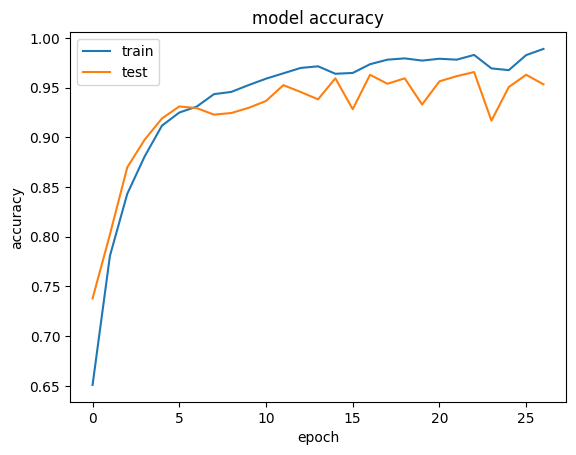

In [37]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

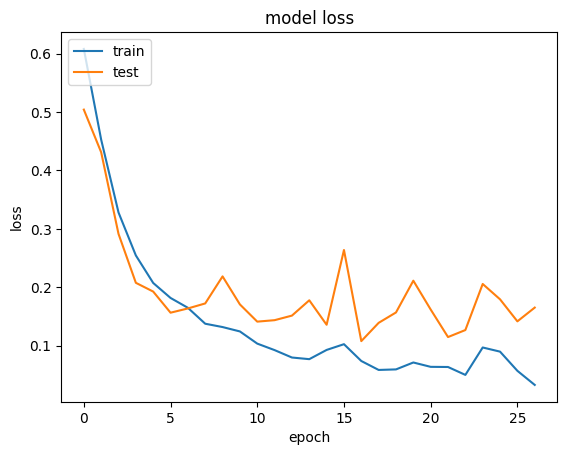

In [38]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Load Save Model

In [39]:
from keras.models import load_model
model = load_model('model.h5')

score = model.evaluate(test_feat, testY, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.10770899802446365
Test accuracy: 0.9629120826721191
